## Dataset

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
Data_path = "/data/behavioral-cloning/train_data_new/"
Img_path = Data_path + "IMG/"
df = pd.read_csv(Data_path + "driving_log.csv", names=['center', 'left', 'right', 'steering', 'gas', 'brake', 'speed'])

df['left'] = df['left'].str.replace('/home/jaeoh2/Tools/linux_sim/train_data_new/',Data_path)
df['right'] = df['right'].str.replace('/home/jaeoh2/Tools/linux_sim/train_data_new/',Data_path)
df['center'] = df['center'].str.replace('/home/jaeoh2/Tools/linux_sim/train_data_new/',Data_path)

In [3]:
df[['center', 'steering']].to_csv(Data_path + 'dataset.txt', header=None, index=None, sep=' ', mode='a')

In [4]:
#data balancing refer from https://navoshta.com/end-to-end-deep-learning/
balanced = pd.DataFrame()
bins = 200
bin_n = 200

start = 0
for end in np.linspace(0, 1, num=bins):
    df_range = df[(np.absolute(df.steering) >= start) & (np.absolute(df.steering) < end)]
    range_n = min(bin_n, df_range.shape[0])
    if range_n > 0:
        balanced = pd.concat([balanced, df_range.sample(range_n)])
    start = end
balanced.to_csv(Data_path + 'driving_log_balanced.csv', index=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88a7eec860>]],
      dtype=object)

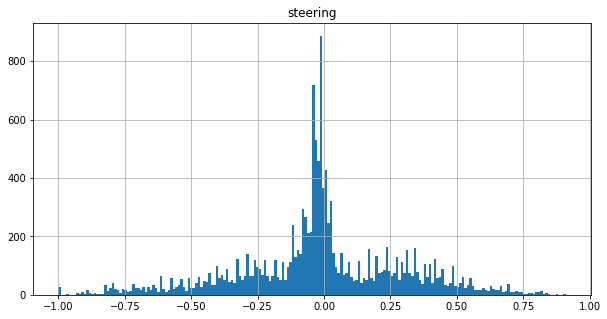

In [5]:
df.hist(column=['steering'], bins=bins, figsize=(10,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88a77ba208>]],
      dtype=object)

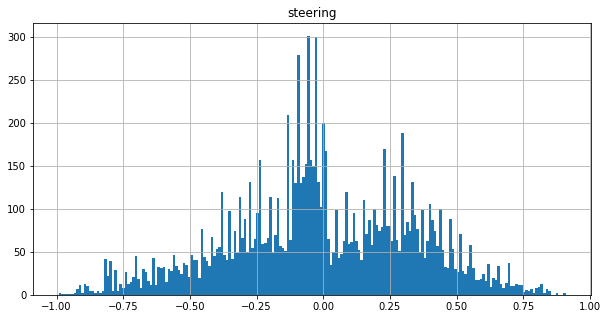

In [6]:
balanced.hist(column=['steering'], bins=bins, figsize=(10,5))

In [7]:
num_examples = len(df)
num_balanced = len(balanced)
print("Number of examples : {}\nNumber of balanced : {}".format(num_examples, num_balanced))

Number of examples : 13977
Number of balanced : 10775


## Data Augmentation

In [8]:
import random
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_utils import *
#from tflearn.data_utils import image_preloader

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
#refer from : https://github.com/tflearn/tflearn/blob/master/tflearn/data_utils.py
def image_preloader(target_path, image_shape, mode='file', normalize=True,
                    grayscale=False, categorical_labels=True,
                    files_extension=None, filter_channel=False):
    assert mode in ['folder', 'file']
    if mode == 'folder':
        images, labels = directory_to_samples(target_path,
                                              flags=files_extension, filter_channel=filter_channel)
    else:
        with open(target_path, 'r') as f:
            images, labels = [], []
            for l in f.readlines():
                l = l.strip('\n').split()
                if not files_extension or any(flag in l[0] for flag in files_extension):
                    if filter_channel:
                        if get_img_channel(l[0]) != 3:
                            continue
                    images.append(l[0])
                    labels.append(l[1])

#     n_classes = np.max(labels) + 1
    X = ImagePreloader(images, image_shape, normalize, grayscale)
    Y = LabelPreloader(labels, n_classes, categorical_labels)
    
    return X, Y

In [ ]:
X, Y = image_preloader(Data_path + 'dataset.txt', image_shape=(224, 224), mode='file',
                       categorical_labels=False, normalize=True,
                       files_extension=['.jpg', '.png'], filter_channel=True)

## Model

In [ ]:
import tflearn
from tflearn.data_preprocessing import ImagePreprocessing
import os

In [ ]:
def build_model(input, num_class):
    #vgg16
    x = tflearn.conv_2d(input, 64, 3, activation='relu', scope='conv1_1')
    x = tflearn.conv_2d(x, 64, 3, activation='relu', scope='conv1_2')
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool1')

    x = tflearn.conv_2d(x, 128, 3, activation='relu', scope='conv2_1')
    x = tflearn.conv_2d(x, 128, 3, activation='relu', scope='conv2_2')
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool2')

    x = tflearn.conv_2d(x, 256, 3, activation='relu', scope='conv3_1')
    x = tflearn.conv_2d(x, 256, 3, activation='relu', scope='conv3_2')
    x = tflearn.conv_2d(x, 256, 3, activation='relu', scope='conv3_3')
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool3')

    x = tflearn.conv_2d(x, 512, 3, activation='relu', scope='conv4_1')
    x = tflearn.conv_2d(x, 512, 3, activation='relu', scope='conv4_2')
    x = tflearn.conv_2d(x, 512, 3, activation='relu', scope='conv4_3')
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool4')

    x = tflearn.conv_2d(x, 512, 3, activation='relu', scope='conv5_1')
    x = tflearn.conv_2d(x, 512, 3, activation='relu', scope='conv5_2')
    x = tflearn.conv_2d(x, 512, 3, activation='relu', scope='conv5_3')
    x = tflearn.max_pool_2d(x, 2, strides=2, name='maxpool5')

    x = tflearn.fully_connected(x, 4096, activation='relu', scope='fc6')
    x = tflearn.dropout(x, 0.5, name='dropout1')

    x = tflearn.fully_connected(x, 4096, activation='relu', scope='fc7')
    x = tflearn.dropout(x, 0.5, name='dropout2')
    
    x = tflearn.fully_connected(x, num_class, activation='softmax', scope='fc8', restore=False)
        
    return x
    

In [ ]:
x = tflearn.input_data(shape=[None, 224, 224, 3], name='input')
vgg16 = build_model(x, num_class=1)
# regression = tflearn.regression(vgg16, optimizer='adam', loss='mean_square', metric='accuracy', learning_rate=0.01)
regression = tflearn.regression(vgg16, optimizer='adam', loss='categorical_crossentropy', metric='accuracy', learning_rate=0.01)
model = tflearn.DNN(regression)

In [ ]:
model.fit(X,Y1, n_epoch=5, shuffle=True, show_metric=True, batch_size=32, snapshot_step=500, snapshot_epoch=False, run_id='vgg_oxflowers17')